In [1]:

# All the needed imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Models that are going to be used
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC #SVM using polynomial kernel

In [2]:
# Read the CSV data
dataset = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
### Non-graphical Analysis ###

# Returns the first 5 rows of the dataset initially
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Delete the "id" column from the dataset
dataset = dataset.drop("id", axis=1)

In [5]:
#Checks for missing values
dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# Fills the missing bmi values with the median value for it
dataset["bmi"].fillna(dataset["bmi"].median(), inplace=True) 


In [7]:
# Summary of the dataset (number of rows, columns, data types, memory usage, and non-null values)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
# Basic statistics of each column (count, mean, standard deviation, min, max and percentile of numeric variable)
dataset.describe() 

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


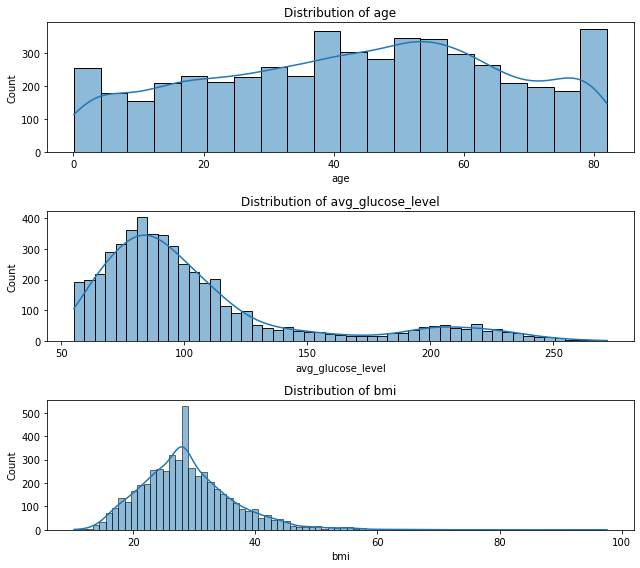

In [9]:
### Graphical Analysis ###

float_cols = dataset.select_dtypes(include=["float64"]).columns.tolist() # age, avg_glucose_level, bmi

# Plot probability density histograms of the distribution for the features that are float64 (age, avg_glucose_level, bmi)
fig = plt.figure(figsize=(9, 8)) # Create a figure with the specified size (9 x 8)
for i, feature in enumerate(float_cols): # Loop through the float_cols list
    plt.subplot(len(float_cols), 1, i + 1) # Creates a subplot arrangement with len(float_cols) rows
    sns.histplot(data=dataset, x=feature, kde=True) # Generates a histogram for the current feature. The kde parameter creates a density curve over the histogram bars.
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


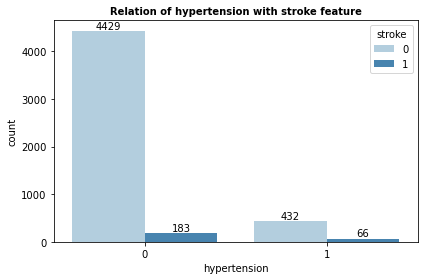

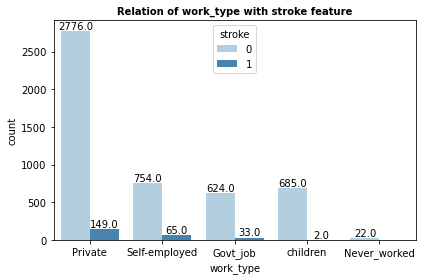

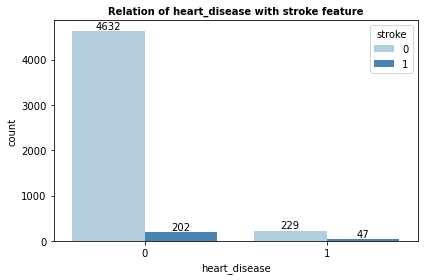

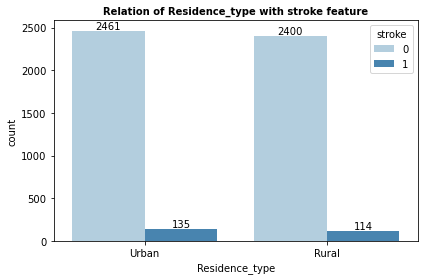

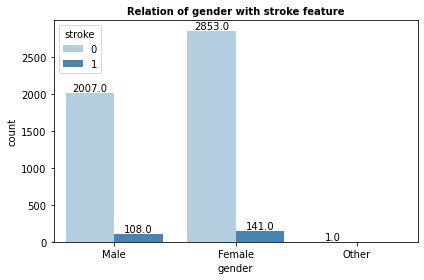

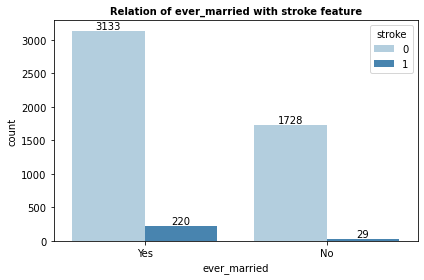

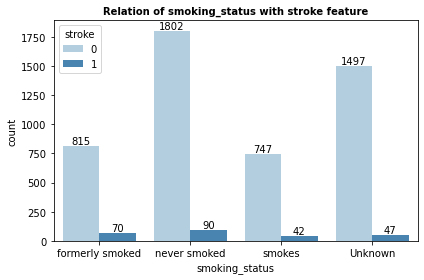

In [10]:
# Function to display a graph to relate each feature with stroke
def plot_relation_stroke(data, column):
    plt.figure(figsize=(6, 4)) # Create a figure with the specified size (6 x 4) 
    ax = sns.countplot(data=data, x=column, hue="stroke",palette="Blues") # Generate a countplot for the current feature, using the dataset and coloring the bars based on the target variable ("stroke") 

    # Add labels on top of the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="bottom")

    plt.title(f"Relation of {column} with stroke feature", size=10, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Get a list of all columns
cat_cols=dataset.select_dtypes(include="object").columns.tolist() #["gender", "ever_married", "work_type", "Residence_type", "smoking_status", "stroke"]
int_cols = dataset.select_dtypes(include="int").columns.tolist()
cols = list(set(cat_cols + int_cols))  # ["Residence_type", "smoking_status", "work_type", "stroke", "ever_married", "heart_disease", "hypertension", "gender"]
cols.remove("stroke")

# Call the function for each column
for category in cols:
    plot_relation_stroke(dataset, category)  

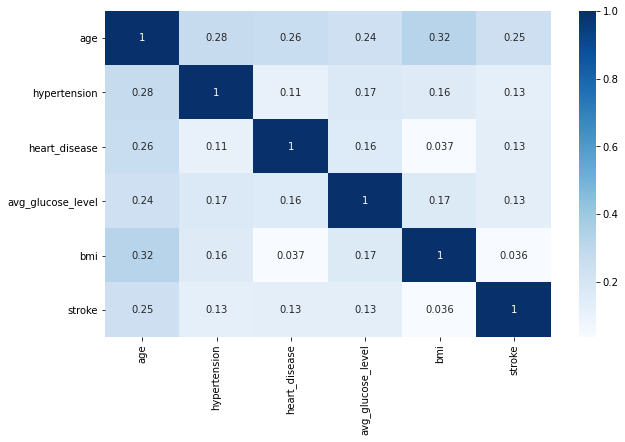

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.corr(), annot=True, cmap="Blues")
plt.show()


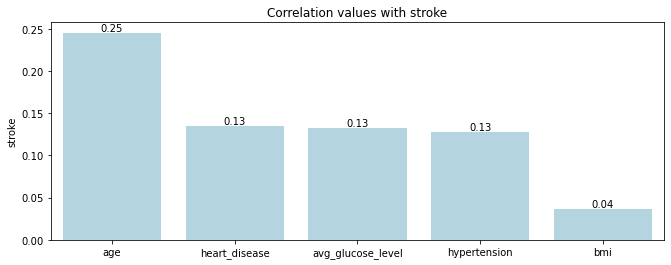

In [12]:
# Get the correlation between the different features with stroke in descending order
corr = dataset.corr()["stroke"].sort_values(ascending=False) 

# Drop outcome feature (stroke)
corr.drop("stroke", inplace=True)

plt.figure(figsize=(11, 4))
ax = sns.barplot(x=corr.keys(), y=corr, palette=["lightblue"]) # Generate a bar plot
for p in ax.patches: # Loop over each bar patch in the barplot
    height = p.get_height()
    ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2., height), ha="center", va="bottom") # Add the correlation value above each bar
plt.title("Correlation values with stroke")
plt.show()


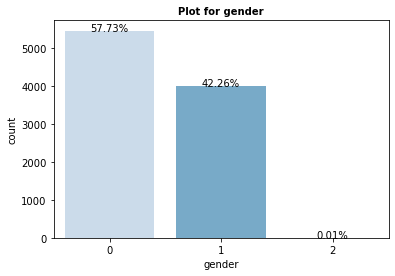

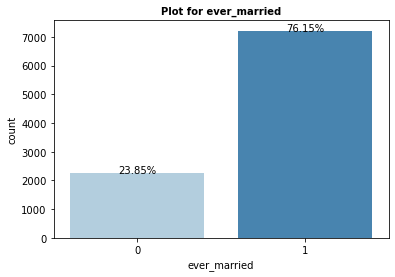

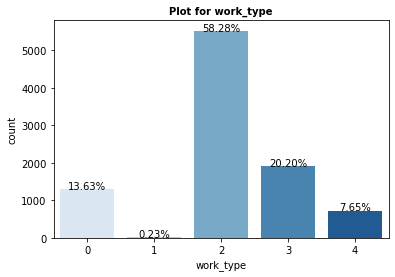

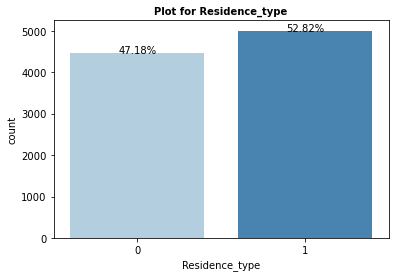

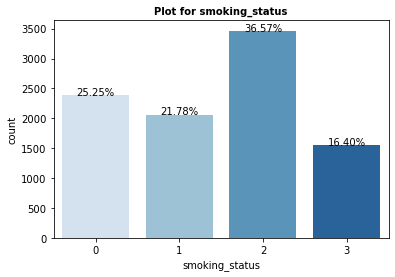

In [24]:
# Function to display a plot with percentages for the given category 
def plot_with_percentages(data, column_name, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    total = float(len(data)) # Total number of data points
    ax = sns.countplot(x=column_name, data=data, palette="Blues") # Countplot for the specified column
    
    # Loop to add the percentages to the bars
    for p in ax.patches: # Loop through each bar patch in the countplot
        height = p.get_height()
        ax.annotate(f"{height/total:.2%}", (p.get_x() + p.get_width() / 2., height), ha="center") # Adds the percentage value above each bar
    plt.title(f"Countplot for {column_name}", size=10, fontweight="bold")
    plt.show()

for category in cat_cols: # Go through all the categorical feautures
    plot_with_percentages(dataset, category)
    

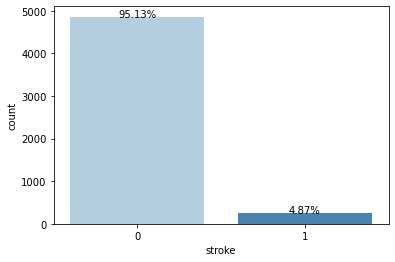

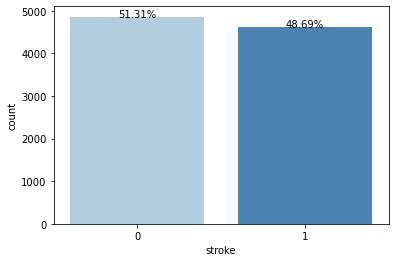

In [14]:

#Plot to compare the data before the balancement of the data
plot_with_percentages(dataset, "stroke")

###  Process to balance the data ###

# Separate the majority and minority classes
majority_class = dataset[dataset["stroke"] == 0] # majority class
minority_class = dataset[dataset["stroke"] == 1] # minority class

# Oversample the minority class
minority_class_upsampled = resample(minority_class, replace=True, n_samples=(len(majority_class) - len(minority_class))) # Oversample the minority clas where n_samples parameter specifies the number of new samples 
balanced_dataset = pd.concat([majority_class, minority_class_upsampled]) # Combine the majority class data with the oversampled minority class

#Plot to compare the data after the balancement of the data
plot_with_percentages(balanced_dataset, "stroke")

dataset = balanced_dataset

In [15]:
label_encoder = LabelEncoder()

# Transform categorical values into numerical (e.g., male and female to 0 and 1)
dataset["gender"] = label_encoder.fit_transform(dataset["gender"])
dataset["ever_married"] = label_encoder.fit_transform(dataset["ever_married"])
dataset["work_type"] = label_encoder.fit_transform(dataset["work_type"]) 
dataset["Residence_type"] = label_encoder.fit_transform(dataset["Residence_type"]) 
dataset["smoking_status"] = label_encoder.fit_transform(dataset["smoking_status"]) 
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,1,3.0,0,0,0,4,0,95.12,18.0,0,0
250,1,58.0,1,0,1,2,1,87.96,39.2,2,0
251,0,8.0,0,0,0,2,1,110.89,17.6,0,0
252,0,70.0,0,0,1,2,0,69.04,35.9,1,0
253,1,14.0,0,0,0,1,0,161.28,19.1,0,0


In [16]:
# Set X and y
X = dataset.drop(["stroke"], axis=1)
y = dataset["stroke"]

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [17]:
### Scaling ###

# Scale the data using Standard Scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) # Fit the StandardScaler object to the training data 
X_test = scaler.transform(X_test) # Transform the testing data using the fitted StandardScaler object. 

In [18]:
# Dictionary with models that are going to be used
models_dict = {
  "LogisticRegression": [LogisticRegression()],
  "DecisionTree": [DecisionTreeClassifier()],
  "RandomForest": [RandomForestClassifier()],
  "KNeighbors": [KNeighborsClassifier()],
  "SVC": [SVC()]
}


Accuracy for LogisticRegression: 75.05%
Training Score for LogisticRegression: 76.11%
Testing Score for LogisticRegression: 75.05%
[[896 328]
 [263 882]]


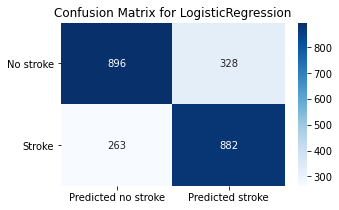

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1224
           1       0.73      0.77      0.75      1145

    accuracy                           0.75      2369
   macro avg       0.75      0.75      0.75      2369
weighted avg       0.75      0.75      0.75      2369



Accuracy for DecisionTree: 97.09%
Training Score for DecisionTree: 100.00%
Testing Score for DecisionTree: 97.09%
[[1155   69]
 [   0 1145]]


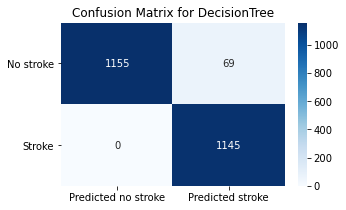

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1224
           1       0.94      1.00      0.97      1145

    accuracy                           0.97      2369
   macro avg       0.97      0.97      0.97      2369
weighted avg       0.97      0.97      0.97      2369



Accuracy for RandomForest: 98.69%
Training Score for RandomForest: 100.00%
Testing Score for RandomForest: 98.69%
[[1193   31]
 [   0 1145]]


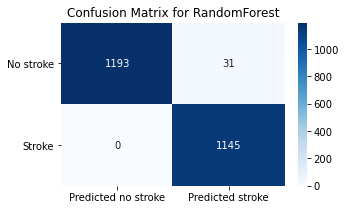

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1224
           1       0.97      1.00      0.99      1145

    accuracy                           0.99      2369
   macro avg       0.99      0.99      0.99      2369
weighted avg       0.99      0.99      0.99      2369



Accuracy for KNeighbors: 91.35%
Training Score for KNeighbors: 94.28%
Testing Score for KNeighbors: 91.35%
[[1019  205]
 [   0 1145]]


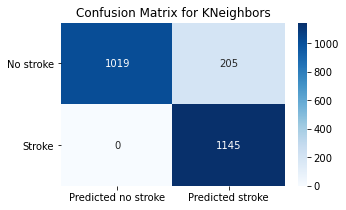

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1224
           1       0.85      1.00      0.92      1145

    accuracy                           0.91      2369
   macro avg       0.92      0.92      0.91      2369
weighted avg       0.93      0.91      0.91      2369



Accuracy for SVC: 80.71%
Training Score for SVC: 83.98%
Testing Score for SVC: 80.71%
[[923 301]
 [156 989]]


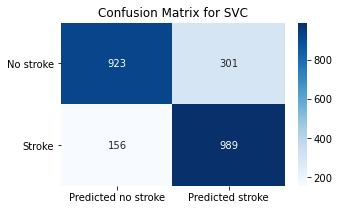

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1224
           1       0.77      0.86      0.81      1145

    accuracy                           0.81      2369
   macro avg       0.81      0.81      0.81      2369
weighted avg       0.81      0.81      0.81      2369





In [19]:

for model_name, model in models_dict.items():
    
    model[0].fit(X_train, y_train) # Fit the model
    
    y_pred = model[0].predict(X_test) # Make predictions 
    
    model.append(accuracy_score(y_test, y_pred)) # Accuracy 
    print(f"Accuracy for {model_name}: {model[1] * 100:.2f}%")

    # Scores
    model.append(model[0].score(X_train, y_train)) # Training score
    print(f"Training Score for {model_name}: {model[2] * 100:.2f}%")
    model.append(model[0].score(X_test, y_test)) # Testing score
    print(f"Testing Score for {model_name}: {model[3] * 100:.2f}%")

    #Cofusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    # Visualizing Confusion Matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, cmap="Blues", annot=True, fmt="d", yticklabels=["No stroke", "Stroke"], xticklabels=["Predicted no stroke", "Predicted stroke"])
    plt.yticks(rotation=0)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
    #Classification Report
    print(classification_report(y_test, y_pred))
    print("\n")


In [20]:
# Creates a DataFrame to summarize the performance of the different models
models_dataset = pd.DataFrame({ 
    "Model Name": list(models_dict.keys()),
    "Accuracy": [value[1] for value in models_dict.values()],
    "Training Score": [value[2] for value in models_dict.values()],
    "Testing Score": [value[3] for value in models_dict.values()],    
})

print(models_dataset)

           Model Name  Accuracy  Training Score  Testing Score
0  LogisticRegression  0.750528        0.761120       0.750528
1        DecisionTree  0.970874        1.000000       0.970874
2        RandomForest  0.986914        1.000000       0.986914
3          KNeighbors  0.913466        0.942849       0.913466
4                 SVC  0.807092        0.839809       0.807092


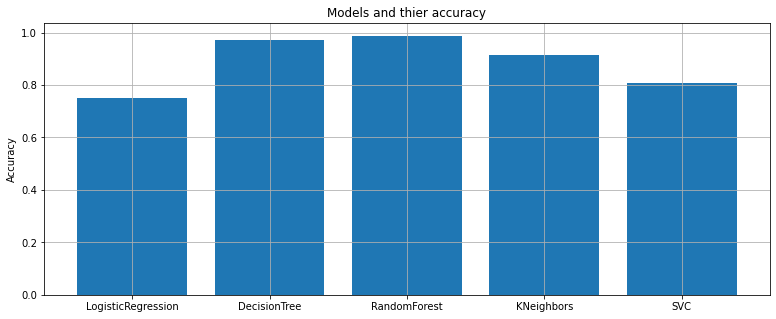

In [21]:
# Generate a bar chart to visualize the accuracy scores of the different machine learning models
plt.figure(figsize=(13, 5))
plt.bar(range(len(models_dict)), list(value[1] for value in models_dict.values())) # Generate a bar plot 
plt.xticks(range(len(models_dict)), list(models_dict.keys())) # Set the x-axis ticks corresponding to the model names stored
plt.ylabel ("Accuracy")
plt.title("Models and thier accuracy")
plt.grid()
plt.show()

In [22]:
### Model Tuning ###

# Define the hyperparameter search space for each model
param_grids = {
  "LogisticRegression": {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "penalty": ["l1", "l2", "elasticnet", "none"]
  },
  "DecisionTree": {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
  },
  "RandomForest": {
    "n_estimators": [10, 50, 100, 200], 
    "max_depth": [None, 10, 20, 30], 
    "min_samples_split": [2, 5, 10],     
    "min_samples_leaf": [1, 2, 4],      
    "max_features": ["auto", "sqrt", "log2"]
  },
  "KNeighbors": {
    "n_neighbors": [5, 10, 20, 50, 100],
    "weights": ["uniform", "distance"]
  },
  "SVC": {
    "C": [0.1, 1, 10, 100],                
    "kernel": ["linear", "rbf", "poly"],      
    "degree": [3, 5, 7],                     
  }
}


In [23]:

# Perform grid search on each model
for model_name, model in models_dict.items():    
  # Create GridSearchCV with cross-validation
  grid_search = GridSearchCV(estimator=model[0], param_grid=param_grids[model_name], cv=3)
  
  # Fit the model with different hyperparameter combinations on the training set
  grid_search.fit(X_train, y_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  print(f"Best Hyperparameters for {model_name}:", best_params)

  # Get the best model
  best_model = grid_search.best_estimator_

  # Now you can use the best_model for predictions or further evaluation
  y_pred = best_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  # Print the accuracy of the best model
  print(f"Accuracy of the best model for {model_name}: {accuracy:.2f}")

  # Evaluate the best model on the test set
  best_model_score = best_model.score(X_test, y_test)
  print(f"Score of the best model for {model_name}: {best_model_score}")
  print("\n")

Best Hyperparameters for LogisticRegression: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy of the best model for LogisticRegression: 0.75
Score of the best model for LogisticRegression: 0.7539046010975095


Best Hyperparameters for DecisionTree: {'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy of the best model for DecisionTree: 0.97
Score of the best model for DecisionTree: 0.9666525960320811


Best Hyperparameters for RandomForest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Accuracy of the best model for RandomForest: 0.99
Score of the best model for RandomForest: 0.9873364288729422


Best Hyperparameters for KNeighbors: {'n_neighbors': 5, 'weights': 'distance'}
Accuracy of the best model for KNeighbors: 0.92
Score of the best model for KNeighbors: 0.9214858590122414


Best Hyperparameters for SVC: {'C': 100, 'degree': 5, 'kernel': 'poly'}
Accuracy of the bes